# Week 4

In [41]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
import json
import re
import warnings
import logging

# progress / kaggle
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display

# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse
from scipy.stats import loguniform, randint, uniform
from scipy.special import expit, logit

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn import clone
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
    ParameterSampler,
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
import sklearn.model_selection._search as sk_search
import sklearn.model_selection._validation as sk_validation

from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    MultiLabelBinarizer,
    Normalizer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    get_scorer,
)
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    f_regression,
    SelectKBest,
    mutual_info_classif,
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeClassifier,
    LogisticRegression,
    RidgeCV,
    LassoCV,
    ElasticNetCV,
)
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import permutation_importance

# extra joblib tools
from joblib import Parallel, delayed, parallel_backend

# =============================
# Global Settings
# =============================
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)

random_state = 42
N_ROWS = 1_000_000
pd.set_option("display.float_format", lambda x: f"{x:.6f}")  # no scientific notation

# =============================
# Small Helpers
# =============================
def is_sparse_dtype(dtype):
    return isinstance(dtype, pd.SparseDtype)


def dollar_format(x, pos=None):
    # format money
    return f"${x:,.0f}"

def format_hms(seconds):
    # format seconds to H:M:S
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder_path, file_name, **kwargs):
    # try to read csv
    full_path = os.path.join(folder_path, file_name) if folder_path is not None else None
    if full_path is not None and os.path.exists(full_path):
        return pd.read_csv(full_path, **kwargs)
    return None

def list_csvs(folder_path):
    # list csv files
    if folder_path is None or not os.path.exists(folder_path):
        return []
    return [f for f in os.listdir(folder_path) if f.lower().endswith(".csv")]

def simple_random_sample(data_frame, n_rows=None, frac=None, random_state=42):
    # simple sample
    if data_frame is None:
        raise ValueError("data_frame is None")
    total_rows = len(data_frame)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be between 0 and 1")
        pick_rows = int(np.floor(frac * total_rows))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        pick_rows = min(int(n_rows), total_rows)
    if pick_rows >= total_rows:
        print("simple_random_sample: taking all rows")
        return data_frame.copy()

    start = time.perf_counter()
    rng = np.random.default_rng(random_state)
    pick_index = rng.choice(total_rows, size=pick_rows, replace=False)
    out_df = data_frame.iloc[pick_index].copy()
    end = time.perf_counter()
    print(f"simple_random_sample: picked {len(out_df)} of {total_rows} rows in {round(end - start, 3)} sec")
    return out_df

def stratified_sample(data_frame, y, n_rows=None, frac=None, random_state=42):
    # stratified sample
    if data_frame is None:
        raise ValueError("data_frame is None")
    y_array = data_frame[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    total_rows = len(data_frame)
    if len(y_array) != total_rows:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be between 0 and 1")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / total_rows, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        print("stratified_sample: taking all rows")
        return data_frame.copy()

    _, counts = np.unique(y_array, return_counts=True)
    if np.any(counts < 2):
        print("stratified_sample: some classes < 2, falling back to simple sample")
        return simple_random_sample(data_frame, n_rows=use_n, frac=use_frac, random_state=random_state)

    start = time.perf_counter()
    index_array = np.arange(total_rows)
    _, test_idx, _, _ = train_test_split(
        index_array, y_array, test_size=test_size, stratify=y_array, random_state=random_state
    )
    out_df = data_frame.iloc[test_idx].copy()
    end = time.perf_counter()
    print(f"stratified_sample: picked {len(out_df)} of {total_rows} rows in {round(end - start, 3)} sec")
    return out_df

def safe_kaggle_download(dataset_name):
    # download from kaggle
    print(f"download: starting {dataset_name}")
    start = time.perf_counter()
    try:
        path = kagglehub.dataset_download(dataset_name)
        end = time.perf_counter()
        print(f"download: done {dataset_name} -> {path} in {round(end - start, 3)} sec")
        return path
    except Exception as e:
        end = time.perf_counter()
        print(f"download: error {dataset_name} -> {str(e)} in {round(end - start, 3)} sec")
        return None

def coerce_datetime_columns(df):
    # make date/time columns into datetime
    if df is None:
        return None
    print("dates: converting possible date/time columns")
    for col_name in df.columns:
        lower = col_name.lower()
        if ("date" in lower) or ("time" in lower):
            try:
                df[col_name] = pd.to_datetime(df[col_name].astype("string"), errors="coerce")
            except Exception:
                pass
    return df

def optimize_dtypes(data_frame, convert_categoricals=True, category_threshold=0.2):
    # shrink memory
    print("optimize_dtypes: start")
    if data_frame is None:
        print("optimize_dtypes: skip because data_frame is None")
        return None

    start_bytes = int(data_frame.memory_usage(deep=True).sum())

    # numeric downsizing
    for col in data_frame.select_dtypes(include=[np.floating]).columns:
        data_frame[col] = pd.to_numeric(data_frame[col], downcast="float")
    for col in data_frame.select_dtypes(include=[np.integer]).columns:
        data_frame[col] = pd.to_numeric(data_frame[col], downcast="integer")

    # object -> category (skip date/time-like names)
    if convert_categoricals:
        object_columns = [
            c for c in data_frame.select_dtypes(include=["object"]).columns
            if ("date" not in c.lower() and "time" not in c.lower())
        ]
        total_rows = max(len(data_frame), 1)

        def is_unhashable_obj(x):
            return isinstance(x, (list, dict, set))

        for col in object_columns:
            series_now = data_frame[col]
            try:
                if series_now.apply(is_unhashable_obj).any():
                    continue
                unique_ratio = series_now.nunique(dropna=False) / total_rows
                if unique_ratio <= category_threshold:
                    data_frame[col] = data_frame[col].astype("category")
            except Exception:
                pass

    end_bytes = int(data_frame.memory_usage(deep=True).sum())
    print(f"optimize_dtypes: memory {round(start_bytes / (1024**2), 2)} MB -> {round(end_bytes / (1024**2), 2)} MB")
    return data_frame

# =============================
# Steam Loader
# =============================
def load_steam_dataset(base_path, n_rows=1_000_000, seed=42):
    print("steam: start")
    if base_path is None:
        print("steam: skip because base_path is None")
        return None

    games = try_read_csv(base_path, "games.csv", low_memory=False)
    users = try_read_csv(base_path, "users.csv", low_memory=False)
    recommendations = try_read_csv(base_path, "recommendations.csv", low_memory=False)

    metadata = None
    meta_path = os.path.join(base_path, "games_metadata.json")
    if os.path.exists(meta_path):
        try:
            metadata = pd.read_json(meta_path, lines=True)
        except Exception as e:
            print(f"steam: metadata read error -> {str(e)}")

    print(f"steam: shapes games={None if games is None else games.shape}, users={None if users is None else users.shape}, recs={None if recommendations is None else recommendations.shape}, meta={None if metadata is None else metadata.shape}")

    steam_table = None
    if recommendations is not None:
        if "is_recommended" in recommendations.columns:
            recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=n_rows, random_state=seed)
        else:
            recs_sample = simple_random_sample(recommendations, n_rows=n_rows, random_state=seed)

        games_plus = games
        if metadata is not None and games is not None and "app_id" in metadata.columns and "app_id" in games.columns:
            print("steam: merge games with metadata")
            games_plus = games.merge(metadata, on="app_id", how="left")

        steam_table = recs_sample
        if games_plus is not None and "app_id" in recs_sample.columns and "app_id" in games_plus.columns:
            print("steam: merge recommendations with games")
            steam_table = steam_table.merge(games_plus, on="app_id", how="left")
        if users is not None and "user_id" in steam_table.columns and "user_id" in users.columns:
            print("steam: merge with users")
            steam_table = steam_table.merge(users, on="user_id", how="left")

        # make dates now
        steam_table = coerce_datetime_columns(steam_table)

        print(f"steam: done shape={None if steam_table is None else steam_table.shape}")
    else:
        print("steam: skip because recommendations.csv is missing")

    return steam_table

# =============================
# Olist Loader
# =============================
def load_olist_dataset(base_path, n_rows=1_000_000, seed=42):
    print("olist: start")
    if base_path is None:
        print("olist: skip because base_path is None")
        return None

    olist_customers = try_read_csv(base_path, "olist_customers_dataset.csv")
    olist_geolocation = try_read_csv(base_path, "olist_geolocation_dataset.csv")
    olist_items = try_read_csv(base_path, "olist_order_items_dataset.csv")
    olist_payments = try_read_csv(base_path, "olist_order_payments_dataset.csv")
    olist_reviews = try_read_csv(base_path, "olist_order_reviews_dataset.csv")
    olist_orders = try_read_csv(base_path, "olist_orders_dataset.csv")
    olist_products = try_read_csv(base_path, "olist_products_dataset.csv")
    olist_sellers = try_read_csv(base_path, "olist_sellers_dataset.csv")
    olist_cat_trans = try_read_csv(base_path, "product_category_name_translation.csv")

    print(
        "olist: shapes "
        f"customers={None if olist_customers is None else olist_customers.shape}, "
        f"geolocation={None if olist_geolocation is None else olist_geolocation.shape}, "
        f"items={None if olist_items is None else olist_items.shape}, "
        f"payments={None if olist_payments is None else olist_payments.shape}, "
        f"reviews={None if olist_reviews is None else olist_reviews.shape}, "
        f"orders={None if olist_orders is None else olist_orders.shape}, "
        f"products={None if olist_products is None else olist_products.shape}, "
        f"sellers={None if olist_sellers is None else olist_sellers.shape}, "
        f"cat_trans={None if olist_cat_trans is None else olist_cat_trans.shape}"
    )

    if not all(x is not None for x in [olist_orders, olist_items, olist_products, olist_sellers, olist_customers]):
        print("olist: skip because core tables are missing")
        return None

    print("olist: sample orders")
    orders_small = simple_random_sample(olist_orders, n_rows=min(n_rows, len(olist_orders)), random_state=seed)

    print("olist: filter items for sampled orders")
    items_small = olist_items[olist_items["order_id"].isin(orders_small["order_id"])].copy()

    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        print("olist: merge category translation")
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    if olist_reviews is not None:
        print("olist: build product review stats")
        product_reviews = (
            items_small[["order_id", "product_id"]]
            .merge(olist_reviews[["order_id", "review_score"]], on="order_id", how="inner")
        )
        product_reviews = product_reviews.drop_duplicates(["order_id", "product_id"])
        product_stats = (
            product_reviews.groupby("product_id", as_index=False)
            .agg(
                review_count_product=("review_score", "count"),
                review_score_mean_product=("review_score", "mean"),
            )
        )
    else:
        product_stats = None

    print("olist: merge items, products, and sellers")
    items_ext = (
        items_small.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    if olist_geolocation is not None:
        print("olist: build basic zip geo")
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        print("olist: merge customers with geo")
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    if olist_payments is not None:
        print("olist: aggregate payments")
        payments_agg = (
            olist_payments.groupby("order_id", as_index=False).agg(
                payment_value_total=("payment_value", "sum"),
                payment_installments_max=("payment_installments", "max"),
                payment_count=("payment_type", "count"),
            )
        )
    else:
        payments_agg = None

    print("olist: assemble main table")
    olist_full = (
        orders_small.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )

    if payments_agg is not None:
        print("olist: merge payments")
        olist_full = olist_full.merge(payments_agg, on="order_id", how="left")

    if product_stats is not None:
        print("olist: merge product stats")
        olist_full = olist_full.merge(product_stats, on="product_id", how="left")

    # make dates now
    olist_full = coerce_datetime_columns(olist_full)

    print(f"olist: shape after assemble {olist_full.shape}")
    print("olist: done")
    return olist_full

# =============================
# VG2019 Loader
# =============================
def load_vg2019_dataset(base_path, n_rows=1_000_000, seed=42):
    print("vg2019: start")
    if base_path is None:
        print("vg2019: skip because base_path is None")
        return None

    csv_files = list_csvs(base_path)
    target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csv_files else (csv_files[0] if csv_files else None)
    if target_csv is None:
        print("vg2019: skip because no csv found")
        return None

    full_path = os.path.join(base_path, target_csv)
    sales = pd.read_csv(full_path, low_memory=False)
    print(f"vg2019: loaded {target_csv} with shape {sales.shape}")

    if "Genre" in sales.columns:
        print("vg2019: stratified sample by Genre")
        sales = stratified_sample(sales, y="Genre", n_rows=n_rows, random_state=seed)
    else:
        print("vg2019: simple random sample")
        sales = simple_random_sample(sales, n_rows=n_rows, random_state=seed)

    print(f"vg2019: done shape={sales.shape}")
    return sales

# =============================
# Download Paths
# =============================
print("main: start downloads")
steam_path = safe_kaggle_download("antonkozyriev/game-recommendations-on-steam")
olist_path = safe_kaggle_download("olistbr/brazilian-ecommerce")
vg2019_path = safe_kaggle_download("ashaheedq/video-games-sales-2019")
print("main: downloads finished")

# =============================
# Load All
# =============================
start_total = time.perf_counter()
steam = load_steam_dataset(steam_path, n_rows=N_ROWS, seed=random_state)
olist = load_olist_dataset(olist_path, n_rows=N_ROWS, seed=random_state)
sales = load_vg2019_dataset(vg2019_path, n_rows=N_ROWS, seed=random_state)
end_total = time.perf_counter()
print(f"main: load all done in {round(end_total - start_total, 3)} sec ({format_hms(end_total - start_total)})")

# =============================
# Optimize Dtypes (after making dates)
# =============================
if steam is not None:
    print("main: optimize steam dtypes")
    steam = optimize_dtypes(steam, convert_categoricals=True, category_threshold=0.2)

if olist is not None:
    print("main: optimize olist dtypes")
    olist = optimize_dtypes(olist, convert_categoricals=True, category_threshold=0.2)

if sales is not None:
    print("main: optimize vg2019 dtypes")
    sales = optimize_dtypes(sales, convert_categoricals=True, category_threshold=0.2)

# =============================
# Final Shapes
# =============================
print("final: shapes summary")
print(f"final: steam shape = {None if steam is None else steam.shape}")
print(f"final: olist shape = {None if olist is None else olist.shape}")
print(f"final: sales shape = {None if sales is None else sales.shape}")



main: start downloads
download: starting antonkozyriev/game-recommendations-on-steam
download: done antonkozyriev/game-recommendations-on-steam -> /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 in 0.26 sec
download: starting olistbr/brazilian-ecommerce
download: done olistbr/brazilian-ecommerce -> /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 in 0.195 sec
download: starting ashaheedq/video-games-sales-2019
download: done ashaheedq/video-games-sales-2019 -> /Users/chandlercampbell/.cache/kagglehub/datasets/ashaheedq/video-games-sales-2019/versions/2 in 0.227 sec
main: downloads finished
steam: start
steam: shapes games=(50872, 13), users=(14306064, 3), recs=(41154794, 8), meta=(50872, 3)
stratified_sample: picked 1000001 of 41154794 rows in 6.206 sec
steam: merge games with metadata
steam: merge recommendations with games
steam: merge with users
dates: converting possible date/time colu

In [45]:

def prepare_all(
    steam, olist, sales,
    top_k_tags=200, max_total_features=400,
    test_size=0.2, random_state=42,
    balance_method="auto",
    min_class_ratio=0.5,
    feature_select_method="none",
    feature_select_k=100,
    task_type="classification",
    scale_method="none",
    poly_degree=2,
    poly_interaction_only=False,
    poly_include_bias=False,
    poly_feature_limit=25
):
    def is_sparse_dtype(dtype):
        return isinstance(dtype, pd.SparseDtype)

    is_classification = str(task_type).lower().startswith("c")

    # forward-selected feature lists you provided
    best_forward_features_raw = {
        "steam": [
            "poly_price_final_log1p^2", "mac", "poly_price_original_log1p",
            "tag_'early access'", "tag_'great soundtrack'", "poly_days_since_release",
            "poly_hours_log1p^2", "tag_'2d'", "tag_'massively multiplayer'",
            "tag_'free to play'", "tag_'cute'", "tag_'action rpg'",
            "poly_price_original_log1p^2", "tag_'first-person'", "tag_'fast-paced'",
            "poly_title_len price_final_log1p", "poly_days_since_release review_year",
            "poly_products_log1p reviews_log1p", "tag_'mmorpg'", "tag_'puzzle'",
            "tag_'pvp'", "poly_desc_len hours_log1p", "poly_hours_log1p",
            "tag_'management'", "tag_'memes'", "tag_'relaxing'", "tag_'visual novel'",
            "tag_'sexual content'", "tag_'difficult'", "tag_'emotional'"
        ],
        "olist": [
            "poly_to_customer_h", "order_status_delivered", "order_status_shipped",
            "poly_to_carrier_h", "seller_state_SP", "order_item_id",
            "product_category_bed_bath_table", "product_category_office_furniture",
            "product_category_furniture_decor", "poly_customer_zip_code_prefix",
            "product_category_watches_gifts", "product_category_computers_accessories",
            "product_category_telephony", "product_category_books_general_interest",
            "product_category_home_confort", "poly_to_customer_h est_delivery_h",
            "poly_to_customer_h price", "order_status_processing", "seller_state_RS",
            "seller_state_PE", "poly_payment_value_per_payment approval_delay_h",
            "product_category_audio", "poly_product_description_lenght product_height_cm",
            "product_name_lenght", "product_category_stationery",
            "product_category_luggage_accessories", "product_category_electronics",
            "seller_state_MA", "product_category_Unknown", "product_category_baby"
        ],
        "sales": [
            "poly_Developer_freq", "Genre_Action", "ESRB_Rating_M", "poly_Year^2",
            "Decade_1970", "Platform_Family_PC", "poly_Developer_freq^2",
            "Platform_Family_Nintendo", "poly_Publisher_freq",
            "poly_Year Publisher_freq", "is_remaster", "Genre_Party", "Genre_Misc",
            "Genre_Simulation", "is_portable", "Genre_Role-Playing", "Decade_1980",
            "Genre_Strategy", "Genre_Fighting", "Genre_Puzzle", "poly_Year",
            "Decade_<NA>", "poly_Year Developer_freq", "poly_Publisher_freq^2",
            "Platform_Family_PlayStation", "Genre_Board Game", "Genre_Racing",
            "Genre_Adventure", "Genre_Shooter"
        ]
    }

    # normalize names like "tag_'great soundtrack'" -> "tag_great soundtrack"
    def _normalize_forward_name(name):
        s = str(name).strip()
        if s.startswith("tag_"):
            rest = s[4:].strip()
            if (rest.startswith("'") and rest.endswith("'")) or (rest.startswith('"') and rest.endswith('"')):
                rest = rest[1:-1]
            return "tag_" + rest.lower()
        return s

    best_forward_features = {
        k: [_normalize_forward_name(n) for n in v]
        for k, v in best_forward_features_raw.items()
    }

    # make poly interaction names order-agnostic
    def canonical_poly_name(name):
        s = str(name)
        if not s.startswith("poly_"):
            return s
        body = s[5:]
        if "^" in body and " " not in body:
            return s  # keep squares like "poly_x^2"
        tokens = body.split()
        tokens = sorted(tokens)
        return "poly_" + " ".join(tokens)

    def build_poly_canonical_map(cols):
        col_map = {}
        for c in cols:
            if c.startswith("poly_"):
                col_map[canonical_poly_name(c)] = c
            else:
                col_map[c] = c
        return col_map

    # small debug print for missing columns (uses canonical poly names)
    def debug_forward_missing(X, dataset_name, best_forward_features):
        expect = best_forward_features.get(dataset_name, [])
        col_map = build_poly_canonical_map(X.columns)
        missing = [f for f in expect if canonical_poly_name(f) not in col_map]
        if missing:
            print(f"[debug] {dataset_name} missing:", missing)
        return missing

    def drop_known_leaks_from_features(X_in, y_in=None):
        leak_names = {"y_is_4_plus", "delivered_late", "target", "label",
                      "target_olist", "target_sales", "target_steam"}
        to_drop = [c for c in X_in.columns if (c in leak_names) or c.lower().startswith("target") or c.lower().startswith("label")]
        X_in = X_in.drop(columns=to_drop, errors="ignore")
        if is_classification and (y_in is not None):
            y_series = pd.Series(y_in).reset_index(drop=True)
            for c in list(X_in.columns):
                xc = pd.Series(X_in[c]).reset_index(drop=True)
                try:
                    ux = set(pd.unique(xc.dropna()))
                    uy = set(pd.unique(y_series.dropna()))
                    if ux <= {0, 1} and uy <= {0, 1}:
                        if (xc.astype("int8") == y_series.astype("int8")).all():
                            X_in = X_in.drop(columns=[c])
                except Exception:
                    pass
        return X_in

    def resample_binary(Xb, yb, method="oversample", random_state=42):
        counts = yb.value_counts(dropna=False)
        if counts.shape[0] != 2:
            return Xb, yb
        majority_class = counts.idxmax()
        minority_class = counts.idxmin()
        majority_idx = yb[yb == majority_class].index.values
        minority_idx = yb[yb == minority_class].index.values
        rng = np.random.RandomState(random_state)
        if method == "undersample":
            keep_majority = rng.choice(majority_idx, size=len(minority_idx), replace=False)
            new_index = np.concatenate([minority_idx, keep_majority])
        else:
            need = int(len(majority_idx) - len(minority_idx))
            need = max(0, need)
            add_minority = rng.choice(minority_idx, size=need, replace=True)
            new_index = np.concatenate([majority_idx, minority_idx, add_minority])
        rng.shuffle(new_index)
        Xb2 = Xb.loc[new_index].reset_index(drop=True)
        yb2 = yb.loc[new_index].reset_index(drop=True)
        return Xb2, yb2

    def split_and_balance(df_in, target_col, balance_method, min_class_ratio, random_state):
        X_in = df_in.drop(columns=[target_col]).copy()
        y_in = df_in[target_col].copy()
        X_in = drop_known_leaks_from_features(X_in, y_in)

        dense_num_cols = [c for c in X_in.select_dtypes(include=[np.number]).columns
                          if not is_sparse_dtype(X_in[c].dtype)]
        for c in dense_num_cols:
            X_in[c] = pd.to_numeric(X_in[c], errors="coerce").fillna(pd.to_numeric(X_in[c], errors="coerce").median())
        obj_cols = X_in.select_dtypes(include=["object"]).columns
        for c in obj_cols:
            X_in[c] = X_in[c].astype("string").fillna("Unknown")

        if is_classification:
            if pd.Series(y_in).nunique() != 2:
                raise ValueError(f"{target_col}: for classification, target must have 2 classes.")
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in.astype(int), test_size=test_size, random_state=random_state, stratify=y_in
            )
        else:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state
            )

        if is_classification:
            vc = y_tr.value_counts()
            ratio = float(vc.min()) / float(vc.max()) if vc.max() > 0 else 1.0
            if balance_method != "none" and ratio < min_class_ratio:
                method = (
                    "oversample" if balance_method == "auto" and len(X_tr) <= 200000
                    else ("undersample" if balance_method == "auto" else balance_method)
                )
                X_tr, y_tr = resample_binary(X_tr, y_tr, method=method, random_state=random_state)
            print(f"{target_col} train class counts:", y_tr.value_counts().to_dict())
            print(f"{target_col} test class counts:", y_te.value_counts().to_dict())
        else:
            def sstats(s):
                return {"n": int(s.shape[0]),
                        "mean": float(np.nanmean(s)),
                        "std": float(np.nanstd(s)),
                        "min": float(np.nanmin(s)),
                        "max": float(np.nanmax(s))}
            print(f"{target_col} train stats:", sstats(y_tr))
            print(f"{target_col} test stats:", sstats(y_te))
        return X_tr, X_te, y_tr, y_te

    def apply_feature_selection(X_tr, y_tr, X_te, method, k, random_state, dataset_name=None):
        if method == "none":
            return X_tr, X_te

        if method in {"forward_best", "forward", "best_forward"}:
            feature_list = best_forward_features.get(dataset_name, [])
            if not feature_list:
                print(f"forward_best: no saved list for {dataset_name}, using all features.")
                return X_tr, X_te

            col_map = build_poly_canonical_map(X_tr.columns)
            kept_cols = []
            for want in feature_list:
                key = canonical_poly_name(want)
                if key in col_map:
                    kept_cols.append(col_map[key])

            missing = [f for f in feature_list if canonical_poly_name(f) not in col_map]
            if missing:
                print(f"forward_best: {dataset_name} missing {len(missing)} of {len(feature_list)} saved features.")

            if not kept_cols:
                print(f"forward_best: none of the saved features found for {dataset_name}, using all features.")
                return X_tr, X_te

            if isinstance(k, int) and k > 0:
                kept_cols = kept_cols[: min(k, len(kept_cols))]

            return X_tr[kept_cols].copy(), X_te[kept_cols].copy()

        n_features = X_tr.shape[1]
        if n_features <= 1 or k >= n_features:
            return X_tr, X_te
        k = int(max(1, min(k, n_features)))
        try:
            if method == "mi":
                if is_classification:
                    sel = SelectKBest(score_func=mutual_info_classif, k=k)
                else:
                    sel = SelectKBest(score_func=f_regression, k=k)
                sel.fit(X_tr, y_tr)
                kept_cols = X_tr.columns[sel.get_support()].tolist()
            elif method == "rf":
                if is_classification:
                    rf = RandomForestClassifier(
                        n_estimators=300, random_state=random_state, n_jobs=-1,
                        class_weight="balanced_subsample"
                    )
                else:
                    rf = RandomForestRegressor(
                        n_estimators=300, random_state=random_state, n_jobs=-1
                    )
                rf.fit(X_tr, y_tr)
                order = np.argsort(rf.feature_importances_)[::-1][:k]
                kept_cols = X_tr.columns[order].tolist()
            else:
                print("feature selection: unknown method, skipping")
                return X_tr, X_te
            return X_tr[kept_cols].copy(), X_te[kept_cols].copy()
        except Exception as e:
            print(f"feature selection error ({method}): {e}. using all features.")
            return X_tr, X_te

    # pick continuous columns, but always keep forced bases (even if low variance)
    def pick_continuous_columns(X, max_cols, must_have=None):
        sample = X.iloc[: min(10000, len(X))].copy()
        num_cols = sample.select_dtypes(include=[np.number]).columns.tolist()

        def ok(col):
            return (not str(X[col].dtype).startswith("uint8")) and (sample[col].nunique(dropna=False) > 2)

        must_have = [c for c in (must_have or []) if c in X.columns and not str(X[c].dtype).startswith("uint8")]
        rest = [c for c in num_cols if ok(c) and c not in must_have]
        if rest:
            var_series = sample[rest].var().sort_values(ascending=False)
            rest_sorted = var_series.index.tolist()
        else:
            rest_sorted = []
        cols = (must_have + [c for c in rest_sorted if c not in must_have])[: max_cols]
        return cols

    def apply_scaling_and_poly(X_tr, X_te):
        # bases needed by your forward polys on Steam
        steam_poly_must_have = [
            "price_final_log1p", "price_original_log1p",
            "days_since_release", "review_year",
            "hours_log1p", "products_log1p", "reviews_log1p",
            "title_len", "desc_len"
        ]
        cont_cols = pick_continuous_columns(X_tr, poly_feature_limit, must_have=steam_poly_must_have)
        X_tr = X_tr.copy()
        X_te = X_te.copy()

        do_scale = (scale_method in {"standard", "minmax"}) and bool(cont_cols)
        do_poly = (poly_degree is not None) and (int(poly_degree) >= 2 or bool(poly_interaction_only)) and bool(cont_cols)

        if not cont_cols:
            return X_tr, X_te

        tr_cont = X_tr[cont_cols].astype("float32").values
        te_cont = X_te[cont_cols].astype("float32").values

        if do_scale:
            if scale_method == "standard":
                scaler = StandardScaler()
            elif scale_method == "minmax":
                scaler = MinMaxScaler()
            else:
                scaler = None
            if scaler is not None:
                tr_cont = scaler.fit_transform(tr_cont).astype("float32")
                te_cont = scaler.transform(te_cont).astype("float32")
                print(f"scaled columns: {len(cont_cols)} with {scale_method}")

        if do_poly:
            poly = PolynomialFeatures(
                degree=int(poly_degree),
                include_bias=bool(poly_include_bias),
                interaction_only=bool(poly_interaction_only)
            )
            tr_poly = poly.fit_transform(tr_cont).astype("float32")
            te_poly = poly.transform(te_cont).astype("float32")
            poly_names = [f"poly_{n}" for n in poly.get_feature_names_out(cont_cols)]
            tr_poly_df = pd.DataFrame(tr_poly, columns=poly_names, index=X_tr.index)
            te_poly_df = pd.DataFrame(te_poly, columns=poly_names, index=X_te.index)
            X_tr = X_tr.drop(columns=cont_cols).join(tr_poly_df)
            X_te = X_te.drop(columns=cont_cols).join(te_poly_df)
            print(f"polynomial features added: {len(poly_names)} (from {len(cont_cols)} columns)")
            return X_tr, X_te

        if do_scale:
            tr_scaled_df = pd.DataFrame(tr_cont, columns=cont_cols, index=X_tr.index).astype("float32")
            te_scaled_df = pd.DataFrame(te_cont, columns=cont_cols, index=X_te.index).astype("float32")
            X_tr = X_tr.drop(columns=cont_cols).join(tr_scaled_df)
            X_te = X_te.drop(columns=cont_cols).join(te_scaled_df)

        return X_tr, X_te

    def prepare_steam_df(steam_in):
        print("prep: steam")
        df = steam_in.copy()
        for col in ["title", "description", "tags"]:
            if col in df.columns:
                df[col] = df[col].astype("string")

        def safe_to_datetime(series):
            return pd.to_datetime(series.astype("string"), errors="coerce")
        for c in ["date", "date_release"]:
            if c in df.columns:
                df[c] = safe_to_datetime(df[c])
            else:
                df[c] = pd.NaT

        df["days_since_release"] = (df["date"] - df["date_release"]).dt.days
        df["days_since_release"] = df["days_since_release"].clip(lower=0).fillna(0).astype("int32")
        df["review_year"] = df["date"].dt.year.astype("float64")
        df["review_month"] = df["date"].dt.month.astype("float64")
        df["review_dow"] = df["date"].dt.dayofweek.astype("float64")
        df["review_year"] = df["review_year"].fillna(-1).astype("int16")
        df["review_month"] = df["review_month"].fillna(-1).astype("int8")
        df["review_dow"] = df["review_dow"].fillna(-1).astype("int8")

        df["title_len"] = df["title"].astype("string").str.len().fillna(0).astype("int32")
        df["desc_len"]  = df["description"].astype("string").str.len().fillna(0).astype("int32")

        for col in ["hours","products","reviews","price_final","price_original"]:
            if col not in df.columns:
                df[col] = np.nan
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df[col + "_log1p"] = np.log1p(df[col])

        df["is_free"] = (df["price_final"] == 0).astype("int8")
        df["discount_ratio"] = np.where(
            pd.to_numeric(df["price_original"], errors="coerce") > 0,
            1.0 - (pd.to_numeric(df["price_final"], errors="coerce") /
                   pd.to_numeric(df["price_original"], errors="coerce")),
            0.0
        )
        df["discount_ratio"] = pd.Series(df["discount_ratio"]).clip(0, 1).fillna(0.0)

        for b in ["win","mac","linux","steam_deck"]:
            if b in df.columns:
                df[b] = (df[b] == True).astype("int8")
            else:
                df[b] = 0

        pos = pd.to_numeric(df.get("positive_ratio"), errors="coerce")
        if is_classification:
            y = (pos >= 80).astype("Int64")
        else:
            y = pos.round().astype("Int64")

        keep_dense = [
            "win","mac","linux","steam_deck",
            "days_since_release","review_year","review_month","review_dow",
            "title_len","desc_len",
            "hours_log1p","products_log1p","reviews_log1p",
            "price_final_log1p","price_original_log1p",
            "discount_ratio","is_free"
        ]
        X = df[keep_dense].copy()

        base_cols_count = X.shape[1]
        allowed_tag_cols = max(0, min(top_k_tags, max_total_features - base_cols_count))
        if allowed_tag_cols > 0 and "tags" in df.columns:
            print("prep: steam build sparse tag matrix")
            tags_clean = (
                df["tags"].astype("string").fillna("").str.lower()
                  .str.replace(r"[\[\]\"]", "", regex=True)
                  .str.replace(";", ",").str.replace("/", ",")
            )
            vec = CountVectorizer(
                tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
                lowercase=False, binary=True, max_features=allowed_tag_cols
            )
            tag_sparse = vec.fit_transform(tags_clean.values)
            tag_df = pd.DataFrame.sparse.from_spmatrix(
                tag_sparse,
                columns=[f"tag_{t}" for t in vec.get_feature_names_out()],
                index=df.index
            ).astype(pd.SparseDtype("uint8", 0))
            X = pd.concat([X, tag_df], axis=1)

            # force-create chosen tags even if not in top-K
            force_tags = [
                "early access","great soundtrack","2d","massively multiplayer","free to play","cute",
                "action rpg","first-person","fast-paced","mmorpg","puzzle","pvp","management","memes",
                "relaxing","visual novel","sexual content","difficult","emotional"
            ]
            def has_tag(series, t):
                pattern = rf"(?:^|,)\s*{re.escape(t)}\s*(?:,|$)"
                return series.str.contains(pattern, regex=True)

            for t in force_tags:
                col = f"tag_{t}"
                if col not in X.columns:
                    X[col] = has_tag(tags_clean, t).astype("uint8")

            # alias variants -> OR into canonical columns
            tag_aliases = {
                "first-person": ["first person"],
                "action rpg": ["action-rpg"],
                "mmorpg": ["mmo rpg", "mmo-rpg"]
            }
            for t, alts in tag_aliases.items():
                col = f"tag_{t}"
                if col not in X.columns:
                    X[col] = has_tag(tags_clean, t).astype("uint8")
                for a in alts:
                    alias_hits = has_tag(tags_clean, a).astype("uint8")
                    if alias_hits.any():
                        X[col] = (X[col].astype("uint8") | alias_hits).astype("uint8")

        if any(is_sparse_dtype(X[c].dtype) for c in X.columns):
            for c in X.columns:
                if is_sparse_dtype(X[c].dtype):
                    X[c] = X[c].sparse.to_dense().astype("uint8")

        dense_num_cols = [c for c in X.select_dtypes(include=[np.number]).columns
                          if not is_sparse_dtype(X[c].dtype)]
        for c in dense_num_cols:
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(pd.to_numeric(X[c], errors="coerce").median())

        raw = df[["date","app_id"]].copy()
        out_df = X.copy()
        out_df["target_steam"] = y
        out_df = out_df[out_df["target_steam"].notna()].copy()
        if is_classification:
            out_df["target_steam"] = out_df["target_steam"].astype("int8")
        else:
            out_df["target_steam"] = out_df["target_steam"].astype("int16")
        return out_df, raw

    def prepare_olist_df(olist_in):
        print("prep: olist")
        o = olist_in.copy()

        def safe_to_datetime(series):
            return pd.to_datetime(series.astype("string"), errors="coerce")
        date_cols = [
            "order_purchase_timestamp","order_approved_at","order_delivered_carrier_date",
            "order_delivered_customer_date","order_estimated_delivery_date","shipping_limit_date",
        ]
        for c in date_cols:
            if c in o.columns:
                o[c] = safe_to_datetime(o[c])
            else:
                o[c] = pd.NaT

        o["purchase_dayofweek"] = o["order_purchase_timestamp"].dt.dayofweek
        o["purchase_month"] = o["order_purchase_timestamp"].dt.month
        o["purchase_hour"] = o["order_purchase_timestamp"].dt.hour

        def to_hours(td):
            return td.dt.total_seconds() / 3600.0

        for c in ["product_length_cm","product_width_cm","product_height_cm","product_weight_g",
                  "payment_installments_max","payment_value_total","payment_count","freight_value","order_item_id"]:
            if c in o.columns:
                o[c] = pd.to_numeric(o[c], errors="coerce")

        o["approval_delay_h"] = to_hours(o["order_approved_at"] - o["order_purchase_timestamp"])
        o["to_carrier_h"] = to_hours(o["order_delivered_carrier_date"] - o["order_purchase_timestamp"])
        o["to_customer_h"] = to_hours(o["order_delivered_customer_date"] - o["order_purchase_timestamp"])
        o["est_delivery_h"] = to_hours(o["order_estimated_delivery_date"] - o["order_purchase_timestamp"])
        o["limit_from_purchase_h"] = to_hours(o["shipping_limit_date"] - o["order_purchase_timestamp"])

        o["delivered_late"] = (o["order_delivered_customer_date"] > o["order_estimated_delivery_date"]).astype("Int64")

        for c in ["product_length_cm","product_width_cm","product_height_cm","product_weight_g"]:
            if c not in o.columns:
                o[c] = np.nan
        o["product_volume_cm3"] = o["product_length_cm"] * o["product_width_cm"] * o["product_height_cm"]
        o["density_g_per_cm3"] = np.where(
            (o["product_volume_cm3"] > 0) & o["product_weight_g"].notna(),
            o["product_weight_g"] / o["product_volume_cm3"],
            np.nan,
        )

        for c in ["payment_installments_max","payment_value_total","payment_count"]:
            if c not in o.columns:
                o[c] = np.nan
        o["avg_installment_value"] = np.where(
            pd.to_numeric(o["payment_installments_max"], errors="coerce") > 0,
            o["payment_value_total"] / o["payment_installments_max"],
            np.nan,
        )
        o["payment_value_per_payment"] = np.where(
            pd.to_numeric(o["payment_count"], errors="coerce") > 0,
            o["payment_value_total"] / o["payment_count"],
            np.nan,
        )

        if "freight_value" not in o.columns:
            o["freight_value"] = np.nan
        o["freight_per_kg"] = np.where(
            pd.to_numeric(o["product_weight_g"], errors="coerce") > 0,
            o["freight_value"] / (o["product_weight_g"] / 1000.0),
            np.nan,
        )

        if "order_item_id" not in o.columns:
            o["order_item_id"] = 1
        o["is_multi_item_order"] = (pd.to_numeric(o["order_item_id"], errors="coerce") > 1).astype("Int64")

        if "product_category_name" in o.columns:
            o["product_category_name"] = o["product_category_name"].astype("string")
        if "product_category_name_english" in o.columns:
            o["product_category_name_english"] = o["product_category_name_english"].astype("string")
        if "product_category_name" in o.columns and "product_category_name_english" in o.columns:
            s1 = o["product_category_name_english"]
            s2 = o["product_category_name"]
            o["product_category"] = s1.mask(s1.isna() | (s1 == ""), s2)
            o = o.drop(columns=["product_category_name","product_category_name_english"])
        elif "product_category_name_english" in o.columns:
            o["product_category"] = o["product_category_name_english"]
            o = o.drop(columns=["product_category_name_english"])
        elif "product_category_name" in o.columns:
            o["product_category"] = o["product_category_name"]
            o = o.drop(columns=["product_category_name"])
        else:
            o["product_category"] = "Unknown"

        for col in ["customer_city","seller_city"]:
            if col in o.columns:
                s_ = o[col].astype("string").fillna("Unknown")
                freq = s_.map(s_.value_counts(normalize=True))
                o[col + "_freq"] = freq.astype(float)
                o = o.drop(columns=[col])

        cat_cols = []
        for c in ["order_status","customer_state","seller_state","product_category"]:
            if c in o.columns:
                cat_cols.append(c)
                o[c] = o[c].astype("string").fillna("Unknown")
        if cat_cols:
            o = pd.get_dummies(o, columns=cat_cols, dtype=np.uint8)

        if "review_score_mean_product" in olist_in.columns:
            base = pd.to_numeric(olist_in["review_score_mean_product"], errors="coerce")
            if is_classification:
                y = (base >= 4.0).astype("Int64")
            else:
                y = base.astype("Float64")
        else:
            print("olist: 'review_score_mean_product' missing; falling back to delivered_late.")
            y = o["delivered_late"].copy()

        o["target_olist"] = y
        o = o[o["target_olist"].notna()].copy()
        if is_classification:
            o["target_olist"] = o["target_olist"].astype("int8")
        else:
            o["target_olist"] = o["target_olist"].astype("float32")

        for leak_col in ["review_score_mean_product","review_count_product","review_score_mean","delivered_late"]:
            if leak_col in o.columns:
                o = o.drop(columns=[leak_col])

        drop_ids = ["order_id","customer_id","customer_unique_id","product_id","seller_id"]
        o = o.drop(columns=[c for c in drop_ids if c in o.columns], errors="ignore")
        o = o.drop(columns=[c for c in date_cols if c in o.columns], errors="ignore")

        num_cols = o.select_dtypes(include=[np.number]).columns.tolist()
        num_cols_no_target = [c for c in num_cols if c != "target_olist"]
        for c in num_cols_no_target:
            o[c] = pd.to_numeric(o[c], errors="coerce").fillna(pd.to_numeric(o[c], errors="coerce").median())
        obj_cols = o.select_dtypes(include=["object"]).columns.tolist()
        for c in obj_cols:
            o[c] = o[c].astype("string").fillna("Unknown")

        return o.copy()
    
    def prepare_sales_df(sales_in):
        print("prep: sales")
        s = sales_in.copy()

        # target
        if "Critic_Score" in s.columns:
            cs = pd.to_numeric(s["Critic_Score"], errors="coerce")
            y = (cs > 8.0).astype("Int64") if is_classification else cs.astype("Float64")
        else:
            y = pd.Series(np.nan, index=s.index, dtype="Float64")

        s["target_sales"] = y
        s = s[s["target_sales"].notna()].copy()
        s["target_sales"] = s["target_sales"].astype("int8" if is_classification else "float32")

        # remove obvious leaks and junk
        leak_cols = ["NA_Sales","PAL_Sales","JP_Sales","Other_Sales","Total_Shipped","Rank","Global_Sales"]
        junk_cols = ["VGChartz_Score","Vgchartzscore","url","img_url","status","Last_Update","basename","User_Score"]
        s = s.drop(columns=[c for c in leak_cols + junk_cols if c in s.columns], errors="ignore")
        if "Critic_Score" in s.columns:
            s = s.drop(columns=["Critic_Score"], errors="ignore")

        # simple remaster flag, then drop Name
        if "Name" in s.columns:
            terms = ["remaster","remastered","hd","definitive","collection","trilogy","anniversary"]
            s["is_remaster"] = s["Name"].astype("string").str.lower().str.contains("|".join(terms), na=False).astype("Int64")
            s = s.drop(columns=["Name"])
        else:
            s["is_remaster"] = pd.Series(0, index=s.index, dtype="Int64")

        # platform family + handheld flag
        def platform_family(p):
            p = "" if pd.isna(p) else str(p).upper()
            if p.startswith("PS") or p in {"PSP","PSV"}: return "PlayStation"
            if p.startswith("X") or p in {"XB","XBLA"}: return "Xbox"
            if p in {"SWITCH","WII","WIIU","GC","N64","SNES","NES","DS","3DS","GB","GBC","GBA"}: return "Nintendo"
            if p == "PC": return "PC"
            if p in {"DC","DREAMCAST","SAT","GEN","MD","MEGADRIVE","GG"}: return "Sega"
            if "ATARI" in p: return "Atari"
            return "Other"

        if "Platform" in s.columns:
            s["Platform_Family"] = s["Platform"].apply(platform_family)
            handhelds = {"DS","3DS","GB","GBC","GBA","PSP","PSV"}
            s["is_portable"] = s["Platform"].astype("string").str.upper().isin(handhelds).astype("Int64")
            s = s.drop(columns=["Platform"])
        else:
            s["Platform_Family"] = "Other"
            s["is_portable"] = pd.Series(0, index=s.index, dtype="Int64")

        # year / decade
        if "Year" in s.columns:
            s["Year"] = pd.to_numeric(s["Year"], errors="coerce")
            s.loc[~s["Year"].between(1970, 2025, inclusive="both"), "Year"] = np.nan
            s["Decade"] = (s["Year"] // 10 * 10).astype("Int64").astype(str)
        else:
            s["Year"] = np.nan
            s["Decade"] = "<NA>"

        # frequency encodes then drop raw strings
        for col in ["Publisher","Developer"]:
            if col in s.columns:
                series = s[col].astype("string").fillna("Unknown")
                freq = series.map(series.value_counts(normalize=True))
                s[col + "_freq"] = freq.astype(float)
                s = s.drop(columns=[col])

        # one-hot encode once, after building the list
        cat_cols = [c for c in ["Genre","ESRB_Rating","Platform_Family","Decade"] if c in s.columns]
        for c in cat_cols:
            s[c] = s[c].astype("string").fillna("Unknown")
        if len(cat_cols) > 0:
            s = pd.get_dummies(s, columns=cat_cols, dtype=np.uint8)

        # numeric cleanup
        num_cols = s.select_dtypes(include=[np.number]).columns.tolist()
        num_cols_no_target = [c for c in num_cols if c != "target_sales"]
        for c in num_cols_no_target:
            s[c] = pd.to_numeric(s[c], errors="coerce").fillna(pd.to_numeric(s[c], errors="coerce").median())

        # object cleanup
        obj_cols = s.select_dtypes(include=["object"]).columns.tolist()
        for c in obj_cols:
            s[c] = s[c].astype("string").fillna("Unknown")

        return s.copy()


    steam_df, steam_raw = prepare_steam_df(steam)
    olist_df = prepare_olist_df(olist)
    sales_df = prepare_sales_df(sales)

    raw_for_split = steam_raw.loc[steam_df.index].copy()
    raw_for_split["date"] = pd.to_datetime(raw_for_split["date"].astype("string"), errors="coerce")
    cutoff_q = 1.0 - float(test_size)
    cutoff_date = raw_for_split["date"].sort_values().quantile(cutoff_q)

    grp_first = raw_for_split.groupby("app_id")["date"].min()
    app_train = set(grp_first[grp_first <= cutoff_date].index.tolist())
    app_test = set(grp_first[grp_first > cutoff_date].index.tolist())

    is_train_mask = raw_for_split["app_id"].isin(app_train)
    is_test_mask = raw_for_split["app_id"].isin(app_test)
    is_train_mask = is_train_mask | (~(is_train_mask | is_test_mask))

    Xs = steam_df.drop(columns=["target_steam"])
    ys = steam_df["target_steam"]

    X_train_steam = Xs[is_train_mask].reset_index(drop=True)
    X_test_steam = Xs[is_test_mask].reset_index(drop=True)
    y_train_steam = ys[is_train_mask].reset_index(drop=True)
    y_test_steam = ys[is_test_mask].reset_index(drop=True)

    print("steam cutoff_date:", pd.to_datetime(cutoff_date))
    print("steam apps in test:", len(app_test), "of", len(grp_first))
    print("steam train rows:", int(X_train_steam.shape[0]), "| test rows:", int(X_test_steam.shape[0]))
    if is_classification:
        print("steam y_train counts:", y_train_steam.value_counts().to_dict())
        print("steam y_test counts:", y_test_steam.value_counts().to_dict())
    else:
        def sstats(s):
            return {"n": int(s.shape[0]),
                    "mean": float(np.nanmean(s)),
                    "std": float(np.nanstd(s)),
                    "min": float(np.nanmin(s)),
                    "max": float(np.nanmax(s))}
        print("steam y_train stats:", sstats(y_train_steam))
        print("steam y_test stats:", sstats(y_test_steam))

    if is_classification:
        if y_train_steam.nunique() == 2:
            vc = y_train_steam.value_counts()
            ratio = float(vc.min()) / float(vc.max()) if vc.max() > 0 else 1.0
            if balance_method != "none" and ratio < min_class_ratio:
                method = "oversample" if (balance_method == "auto" and len(X_train_steam) <= 200000) else \
                         ("undersample" if balance_method == "auto" else balance_method)
                X_train_steam, y_train_steam = resample_binary(X_train_steam, y_train_steam, method=method, random_state=random_state)
                print("steam balanced train counts:", y_train_steam.value_counts().to_dict())

    steam_split = (X_train_steam, X_test_steam, y_train_steam, y_test_steam)

    olist_split = split_and_balance(olist_df, "target_olist", balance_method, min_class_ratio, random_state)
    sales_split = split_and_balance(sales_df, "target_sales", balance_method, min_class_ratio, random_state)

    def scale_poly_wrapper(split):
        Xtr, Xte, ytr, yte = split
        Xtr2, Xte2 = apply_scaling_and_poly(Xtr, Xte)
        return (Xtr2, Xte2, ytr, yte)

    steam_split = scale_poly_wrapper(steam_split)
    olist_split = scale_poly_wrapper(olist_split)
    sales_split = scale_poly_wrapper(sales_split)

    if feature_select_method != "none":
        Xtr, Xte, ytr, yte = steam_split
        Xtr_s, Xte_s = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state, dataset_name="steam"
        )
        steam_split = (Xtr_s, Xte_s, ytr, yte)

        Xtr, Xte, ytr, yte = olist_split
        Xtr_o, Xte_o = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state, dataset_name="olist"
        )
        olist_split = (Xtr_o, Xte_o, ytr, yte)

        Xtr, Xte, ytr, yte = sales_split
        Xtr_v, Xte_v = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state, dataset_name="sales"
        )
        sales_split = (Xtr_v, Xte_v, ytr, yte)

    # show exactly which saved features are missing (after selection)
    _ = debug_forward_missing(steam_split[0], "steam", best_forward_features)
    _ = debug_forward_missing(olist_split[0], "olist", best_forward_features)
    _ = debug_forward_missing(sales_split[0], "sales", best_forward_features)

    print("\nsteam selected features (train, test):", steam_split[0].shape[1], steam_split[1].shape[1])
    print("olist selected features (train, test):", olist_split[0].shape[1], olist_split[1].shape[1])
    print("sales selected features (train, test):", sales_split[0].shape[1], sales_split[1].shape[1])

    return {
        "steam": steam_split,
        "olist": olist_split,
        "sales": sales_split,
        "feature_names": {
            "steam": steam_split[0].columns.tolist(),
            "olist": olist_split[0].columns.tolist(),
            "sales": sales_split[0].columns.tolist(),
        }
    }


def float_range(start, stop, step):
    values = []
    value = start
    while value <= stop:
        values.append(value)
        value += step
    return values


# call
splits = prepare_all(
    steam, olist, sales,
    test_size=0.2,
    random_state=42,
    balance_method="auto",
    min_class_ratio=0.5,
    feature_select_method="none",
    feature_select_k=9999,
    task_type="classification",
    scale_method="none",
    poly_degree=2,
    poly_interaction_only=False,
    poly_include_bias=False,
    poly_feature_limit=20
)

X_train_steam, X_test_steam, y_train_steam, y_test_steam = splits["steam"]
X_train_olist, X_test_olist, y_train_olist, y_test_olist = splits["olist"]
X_train_sales, X_test_sales, y_train_sales, y_test_sales = splits["sales"]


prep: steam
prep: steam build sparse tag matrix
prep: olist
prep: sales
steam cutoff_date: 2022-02-17 00:00:00
steam apps in test: 3212 of 22777
steam train rows: 955509 | test rows: 44492
steam y_train counts: {1: 781248, 0: 174261}
steam y_test counts: {1: 28773, 0: 15719}
steam balanced train counts: {1: 174261, 0: 174261}
target_olist train class counts: {1: 61050, 0: 61050}
target_olist test class counts: {1: 15263, 0: 7422}
target_sales train class counts: {1: 43000, 0: 43000}
target_sales test class counts: {0: 10751, 1: 408}
polynomial features added: 90 (from 12 columns)
polynomial features added: 230 (from 20 columns)
polynomial features added: 9 (from 3 columns)

steam selected features (train, test): 314 314
olist selected features (train, test): 377 377
sales selected features (train, test): 53 53


In [52]:

def run_logistic_regression_comparison(
    X_train_scaled,
    X_train_normalized,
    y_train,
    feature_names=None,
    random_state=42,
    n_iter=20,
    include_normalizer=True
):
    # build the list of methods to try
    methods = [("Standard Scaler", X_train_scaled)]
    if include_normalizer and X_train_normalized is not None:
        methods.append(("Normalizer", X_train_normalized))

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(methods[0][1].shape[1])]

    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # simple, readable search space
    param_choices = {
        "solver": ["lbfgs", "newton-cg"],
        "penalty": ["l2"],
        "C": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
        "max_iter": [800],
        "tol": [0.001],
        "class_weight": ["balanced"]
    }

    all_results = []
    best_method_name = None
    best_search = None
    best_X = None
    best_cv_score = -1.0

    for method_name, X_use in methods:
        # randomized search keeps it fast on larger grids
        search = RandomizedSearchCV(
            estimator=LogisticRegression(random_state=random_state),
            param_distributions=param_choices,
            n_iter=min(n_iter, 50),
            scoring="f1_macro",
            cv=cv_folds,
            n_jobs=-1,
            random_state=random_state,
            refit=True
        )
        search.fit(X_use, y_train)

        all_results.append({
            "Method": method_name,
            "CV F1 Macro Best": float(search.best_score_),
            "Best Params": search.best_params_
        })

        if search.best_score_ > best_cv_score:
            best_cv_score = float(search.best_score_)
            best_method_name = method_name
            best_search = search
            best_X = X_use

    summary_df = pd.DataFrame(all_results).sort_values("CV F1 Macro Best", ascending=False).reset_index(drop=True)

    # plot coefficients only for the best method
    best_model = best_search.best_estimator_
    coef_matrix = best_model.coef_

    # handle binary vs multi-class in a simple way
    if coef_matrix.ndim == 2 and coef_matrix.shape[0] > 1:
        signed_coef = np.mean(coef_matrix, axis=0)
    else:
        signed_coef = coef_matrix.ravel()

    top_k = 10
    top_pos_idx = np.argsort(signed_coef)[-top_k:][::-1]
    top_neg_idx = np.argsort(signed_coef)[:top_k]

    top_pos_features = [feature_names[i] for i in top_pos_idx]
    top_neg_features = [feature_names[i] for i in top_neg_idx]

    # positive side
    plt.figure(figsize=(8, 5))
    plt.barh(top_pos_features[::-1], signed_coef[top_pos_idx][::-1])
    plt.title(f"Top Positive Coefficients • {best_method_name}")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # negative side
    plt.figure(figsize=(8, 5))
    plt.barh(top_neg_features, signed_coef[top_neg_idx])
    plt.title(f"Top Negative Coefficients • {best_method_name}")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return {
        "best_model": best_model,
        "best_method_name": best_method_name,
        "cv_summary": summary_df
    }


In [29]:
standard_scaler = StandardScaler()
X_train_steam_scaled = standard_scaler.fit_transform(X_train_steam)
X_test_steam_scaled = standard_scaler.transform(X_test_steam)
X_train_olist_scaled = standard_scaler.fit_transform(X_train_olist)
X_test_olist_scaled = standard_scaler.transform(X_test_olist)
X_train_sales_scaled = standard_scaler.fit_transform(X_train_sales)
X_test_sales_scaled = standard_scaler.transform(X_test_sales)

normal_scaler = Normalizer()
X_train_steam_normalized = normal_scaler.fit_transform(X_train_steam)
X_test_steam_normalized = normal_scaler.transform(X_test_steam)
X_train_olist_normalized = normal_scaler.fit_transform(X_train_olist)
X_test_olist_normalized = normal_scaler.transform(X_test_olist)
X_train_sales_normalized = normal_scaler.fit_transform(X_train_sales)
X_test_sales_normalized = normal_scaler.transform(X_test_sales)

# Steam Reviews

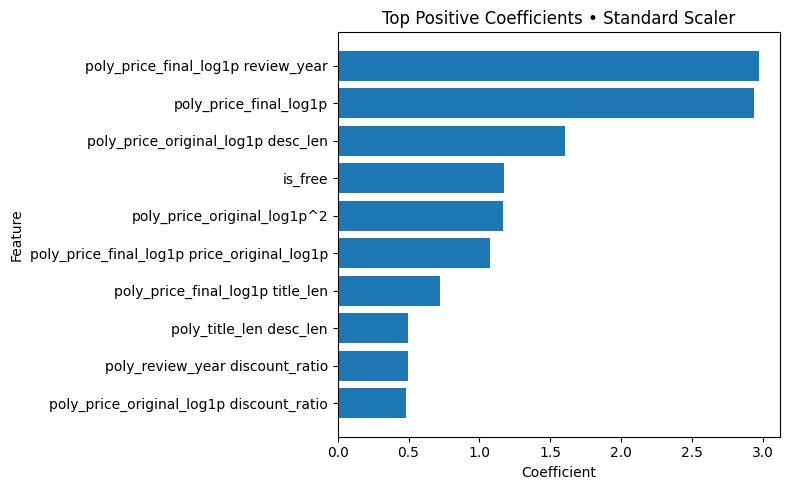

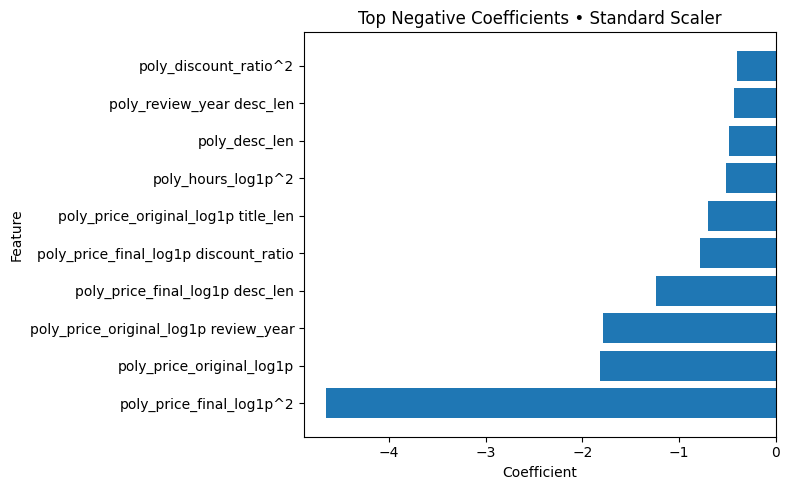

{'best_model': LogisticRegression(class_weight='balanced', max_iter=800, random_state=42,
                    solver='newton-cg', tol=0.001),
 'best_method_name': 'Standard Scaler',
 'cv_summary':             Method  CV F1 Macro Best  \
 0  Standard Scaler          0.779912   
 1       Normalizer          0.630104   
 
                                          Best Params  
 0  {'tol': 0.001, 'solver': 'newton-cg', 'penalty...  
 1  {'tol': 0.001, 'solver': 'newton-cg', 'penalty...  }

In [53]:
summary_steam = run_logistic_regression_comparison(
    X_train_steam_scaled,
    X_train_steam_normalized,
    y_train_steam,
    feature_names=X_train_steam.columns,
    random_state=42
)
summary_steam

# Olist Transactions

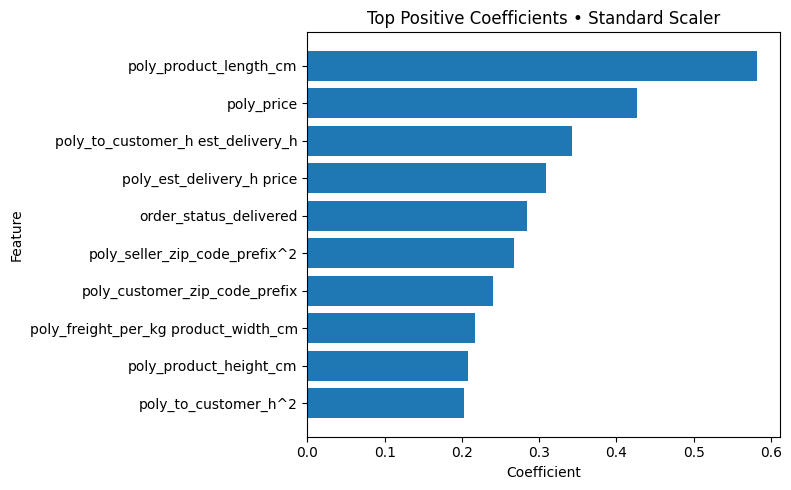

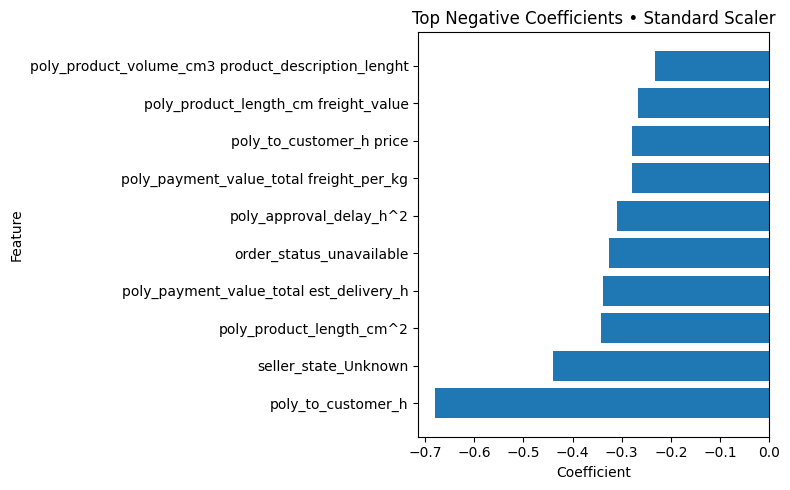

{'best_model': LogisticRegression(C=10.0, class_weight='balanced', max_iter=800,
                    random_state=42, solver='newton-cg', tol=0.001),
 'best_method_name': 'Standard Scaler',
 'cv_summary':             Method  CV F1 Macro Best  \
 0  Standard Scaler          0.649388   
 1       Normalizer          0.563141   
 
                                          Best Params  
 0  {'tol': 0.001, 'solver': 'newton-cg', 'penalty...  
 1  {'tol': 0.001, 'solver': 'newton-cg', 'penalty...  }

In [54]:
summary_olist = run_logistic_regression_comparison(
    X_train_olist_scaled,
    X_train_olist_normalized,
    y_train_olist,
    feature_names=X_train_olist.columns,
    random_state=42
)
summary_olist

# Video Game Sales

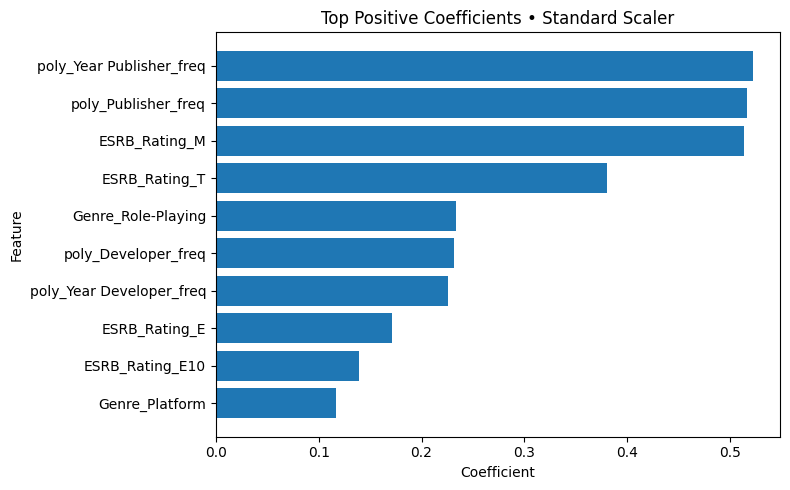

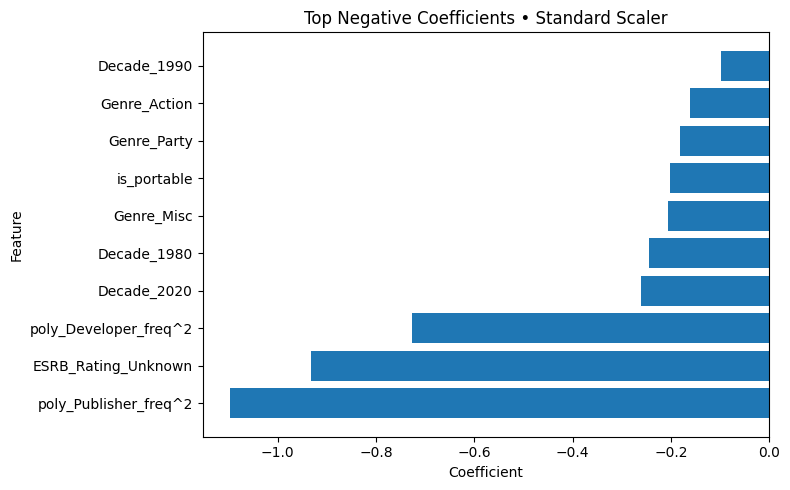

{'best_model': LogisticRegression(C=0.3, class_weight='balanced', max_iter=800,
                    random_state=42, solver='newton-cg', tol=0.001),
 'best_method_name': 'Standard Scaler',
 'cv_summary':             Method  CV F1 Macro Best  \
 0  Standard Scaler          0.786995   
 1       Normalizer          0.333333   
 
                                          Best Params  
 0  {'tol': 0.001, 'solver': 'newton-cg', 'penalty...  
 1  {'tol': 0.001, 'solver': 'lbfgs', 'penalty': '...  }

In [55]:
summary_sales = run_logistic_regression_comparison(
    X_train_sales_scaled,
    X_train_sales_normalized,
    y_train_sales,
    feature_names=X_train_sales.columns,
    random_state=42
)
summary_sales